# 0.2 Single image preprocessing tests

In [10]:
%matplotlib inline

In [11]:
cd /Users/anacriel/plant_seed_classification/

/Users/anacriel/plant_seed_classification


In [12]:
import os
import cv2
import numpy as np
import src.visualization.visualize as vs
import src.features.build_features as bfeatures
from src.data.make_dataset import increase_brightness
from matplotlib import pyplot as plt

In [13]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('dark_background')

In [14]:
cd /Users/anacriel/plant_seed_classification/src

/Users/anacriel/plant_seed_classification/src


In [15]:
data_dir = '../data/processed/'
#image_path = data_dir + 'train/Common Chickweed/c908a478e.png'
#bad case
image_path = data_dir + 'train/Maize/b273efc22.png'

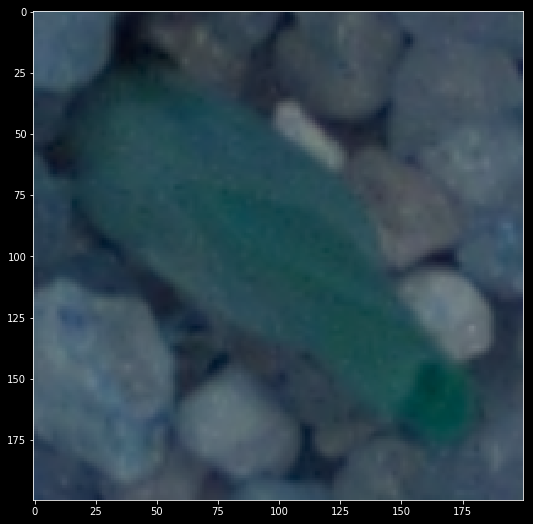

In [16]:
main_img = cv2.imread(image_path)
plt.imshow(main_img)

In [18]:
def cieluv(img, target):
    # adapted from https://www.compuphase.com/cmetric.htm
    img = img.astype('int')
    aR, aG, aB = img[:,:,0], img[:,:,1], img[:,:,2]
    bR, bG, bB = target
    rmean = ((aR + bR) / 2.).astype('int')
    r2 = np.square(aR - bR)
    g2 = np.square(aG - bG)
    b2 = np.square(aB - bB)
    
    # final sqrt removed for speed; please square your thresholds accordingly
    result = (((512+rmean)*r2)>>8) + 4*g2 + (((767-rmean)*b2)>>8)
    
    return result

In [28]:
def process_image(f, plot=True):
    img = plt.imread(f)
    img = np.round(img * 255).astype('ubyte')[:,:,:3]
    if plot:
        plt.figure(1)
        plt.subplot(141)
        plt.imshow(img)
        plt.title('Raw Image')
    img_filter = (
        (cieluv(img, (71, 86, 38)) > 1600)
        & (cieluv(img, (65,  79,  19)) > 1600)
        & (cieluv(img, (95,  106,  56)) > 1600)
        & (cieluv(img, (56,  63,  43)) > 500)
    )
    img[img_filter] = 0
    
    if plot:
        plt.subplot(142)
        plt.imshow(img)
        plt.title('CIELUV Color Thresholding')
    
    img = cv2.medianBlur(img, 9)
    
    if plot:
        plt.subplot(143)
        plt.imshow(img)
        plt.title('Median filter')
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype('uint8')
    
    if plot:
        plt.subplot(144)
        plt.imshow(img)
        plt.title('Black and White')
    return img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

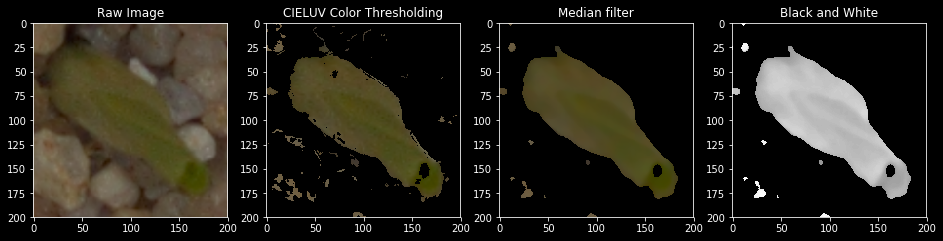

In [29]:
process_image(image_path)

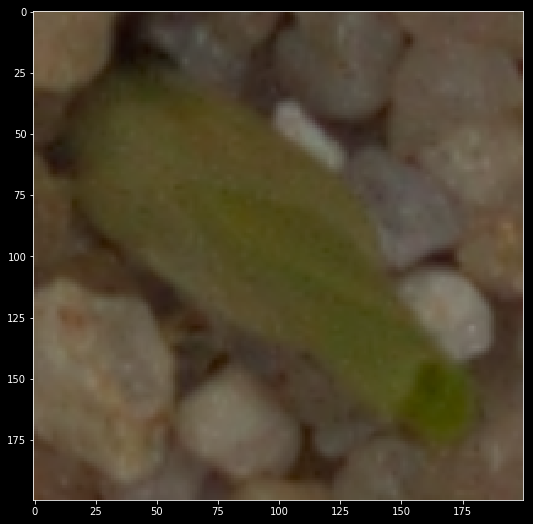

In [21]:
b,g,r = cv2.split(main_img)     
rgb_main_img = cv2.merge([r,g,b])
plt.imshow(rgb_main_img)

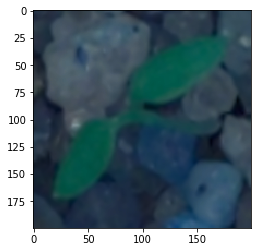

In [62]:
# numeric params define filter strength: for the whole image and   
# for each channel if the image is colored
# Ref. to the Non-local Means Denoising algorithm (if it is needed in the report):
# http://www.ipol.im/pub/art/2011/bcm_nlm/article.pdf
main_img = cv2.fastNlMeansDenoisingColored(main_img,None,5,5,5,5) 
plt.imshow(main_img)

## Explore colors for better segmentation (not implemented yet)

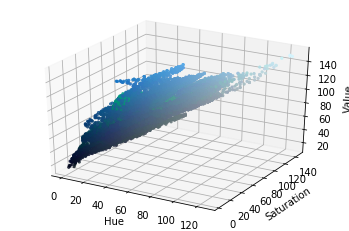

In [63]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors


pixel_colors = main_img.reshape((np.shape(main_img)[0]*np.shape(main_img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

h, s, v = cv2.split(main_img)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

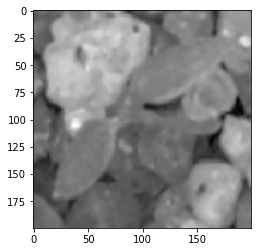

In [64]:
main_img_gs = cv2.cvtColor(main_img, cv2.COLOR_RGB2GRAY)
plt.imshow(main_img_gs, cmap='Greys_r')

## Denoise image

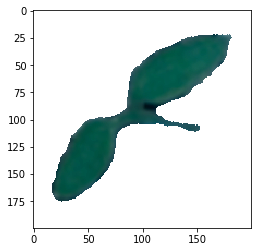

In [65]:
image_list = [main_img]
img_seg_list = vs.segment_plant(image_list, data_type='test', sharpen=True)
plt.imshow(main_img)
plt.imshow(img_seg_list[0])

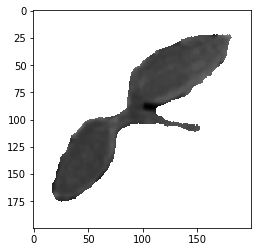

In [66]:
gs = cv2.cvtColor(img_seg_list[0], cv2.COLOR_RGB2GRAY)
plt.imshow(gs, cmap='Greys_r')

## Adaptive image thresholding using Otsu's thresholding method

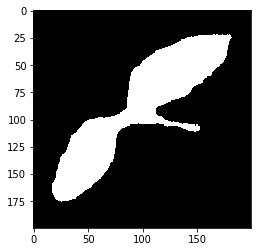

In [67]:
ret_otsu, im_bw_otsu = cv2.threshold(gs, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(im_bw_otsu, cmap='Greys_r')

## Closing of holes using Morphological Transformation

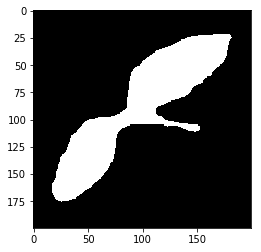

In [68]:
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing,cmap='Greys_r')

## Boundary extraction using contours

In [69]:
contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

len(contours)

1

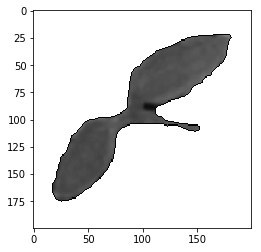

In [70]:
plottedContour = cv2.drawContours(gs,contours,-1,(0,255,0),1)
plt.imshow(plottedContour,cmap="Greys_r")

## Count features

In [71]:
cnt = contours[0]
M = cv2.moments(cnt)
M

{'m00': 7454.0,
 'm10': 717489.3333333333,
 'm01': 671660.3333333333,
 'm20': 83455623.0,
 'm11': 52252197.33333333,
 'm02': 73492393.0,
 'm30': 10792378067.2,
 'm21': 5204068937.566667,
 'm12': 4734826102.566667,
 'm03': 9088396183.7,
 'mu20': 14393247.973556355,
 'mu11': -12398879.241630137,
 'mu02': 12970847.068494186,
 'mu30': -11555806.597232819,
 'mu21': 71025690.93323922,
 'mu12': -104768387.6205132,
 'mu03': 128652138.74087715,
 'nu20': 0.25904787307877825,
 'nu11': -0.22315347460183366,
 'nu02': 0.23344767986327564,
 'nu30': -0.0024089444961842245,
 'nu21': 0.014806144929967908,
 'nu12': -0.021840208955467164,
 'nu03': 0.02681905922658644}

In [72]:
area = cv2.contourArea(cnt)
area

7454.0

In [73]:
perimeter = cv2.arcLength(cnt,True)
perimeter

613.6711342334747

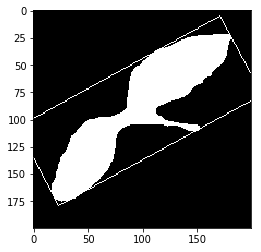

In [74]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
contours_im = cv2.drawContours(closing,[box],0,(255,255,255),1)
plt.imshow(contours_im,cmap="Greys_r")

In [75]:
x,y,w,h = cv2.boundingRect(cnt)
aspect_ratio = float(w)/h
aspect_ratio

1.077922077922078

In [76]:
rectangularity = w*h/area
rectangularity

3.429568017171988

In [77]:
circularity = ((perimeter)**2)/area
circularity

50.52217077963501

In [78]:
equi_diameter = np.sqrt(4*area/np.pi)
equi_diameter

97.42036525519653

## Color based features

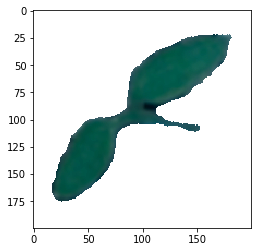

In [79]:
plt.imshow(img_seg_list[0],cmap="Greys_r")

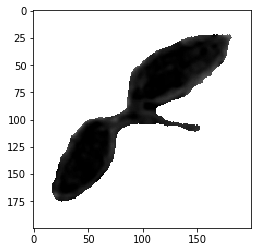

In [80]:
red_channel = img_seg_list[0][:,:,0]
plt.imshow(red_channel,cmap="Greys_r")

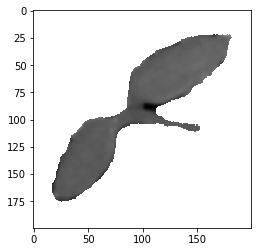

In [81]:
green_channel = img_seg_list[0][:,:,1]
plt.imshow(green_channel,cmap="Greys_r")

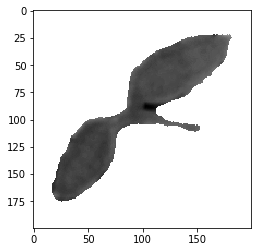

In [82]:
blue_channel = img_seg_list[0][:,:,2]
plt.imshow(blue_channel,cmap="Greys_r")

In [83]:
np.mean(blue_channel)

220.5637

In [84]:
blue_channel[blue_channel == 255] = 0
green_channel[green_channel == 255] = 0
red_channel[red_channel == 255] = 0

In [85]:
red_mean = np.mean(red_channel)
red_mean

2.927975

In [86]:
green_mean = np.mean(green_channel)
green_mean

16.186675

In [87]:
blue_mean = np.mean(blue_channel)
blue_mean

14.6512

In [88]:
red_var = np.std(red_channel)
red_var

9.043449972182906

## Texture based features

In [89]:
import mahotas as mt

In [90]:
textures = mt.features.haralick(gs)
ht_mean = textures.mean(axis=0)
ht_mean

array([ 6.40174230e-01,  7.46520823e+02,  9.39210771e-01,  6.13866005e+03,
        8.93613496e-01,  4.33391869e+02,  2.38081194e+04,  1.92830275e+00,
        2.29321752e+00,  2.87318170e-03,  1.03406291e+00, -6.13205833e-01,
        9.31285131e-01])

In [91]:
print(ht_mean[1]) #contrast
print(ht_mean[2]) #correlation
print(ht_mean[8]) #entropy

746.5208234009243
0.9392107706393008
2.2932175195178197
